In [133]:
# Import libraries
import pandas as pd
import glob 
import numpy as np
import matplotlib.pyplot as plt
import os
import skgstat as skg
from skgstat import models
import gstatsim as gs
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import QuantileTransformer 
import pyproj # for reprojection
from pykrige.ok import OrdinaryKriging

In [134]:
# Fields paths
field_a_paths = glob.glob("D:/Cours bioingé/BIR M2/Mémoire/Data/Drone GPR/Field A/*.txt") # return all file paths that match a specific pattern
field_b_paths = glob.glob("D:/Cours bioingé/BIR M2/Mémoire/Data/Drone GPR/Field B/*.txt")

In [135]:
sample_number = 5           # [0-10]
field_path = field_b_paths  # field_a_paths or field_b_paths

In [136]:
# Define the transformer for WGS84 to UTM (UTM zone 32N)
transformer = pyproj.Transformer.from_crs("epsg:4326", "epsg:32632", always_xy=True)

In [137]:
# Import data function
gpr_data_tables = []
def import_data(file_paths=glob.glob("D:/Cours bioingé/BIR M2/Mémoire/Data/Drone GPR/Field A/*.txt")):
    gpr_data_tables = []
    for file_path in file_paths:
        data_frame = pd.read_csv(file_path, sep = "  ", engine="python") # read csv file
        data_frame.columns = ['y', 'x', 'vwc'] # rename columns
        gpr_data_tables.append(data_frame)

    return gpr_data_tables

# Extract dates function
dates = []
def extract_dates(file_paths=glob.glob("D:/Cours bioingé/BIR M2/Mémoire/Data/Drone GPR/Field A/*.txt")):
    for file_path in file_paths:
        file_name = os.path.basename(file_path)
        file_name_without_extension = os.path.splitext(file_name)[0]
        date = file_name_without_extension[4:6] + "/" + file_name_without_extension[2:4] + "/" + "20" + file_name_without_extension[:2]
        dates.append(date)
        
    return dates

In [138]:
# Letter of the field
if field_path == field_a_paths:
    field_letter = "A"
else:
    field_letter = "B"

# Date of the files
extract_dates(field_path)

['16/05/2023',
 '04/07/2023',
 '19/07/2023',
 '07/08/2023',
 '06/09/2023',
 '18/09/2023',
 '04/10/2023',
 '16/10/2023',
 '06/11/2023',
 '05/02/2024',
 '13/03/2024']

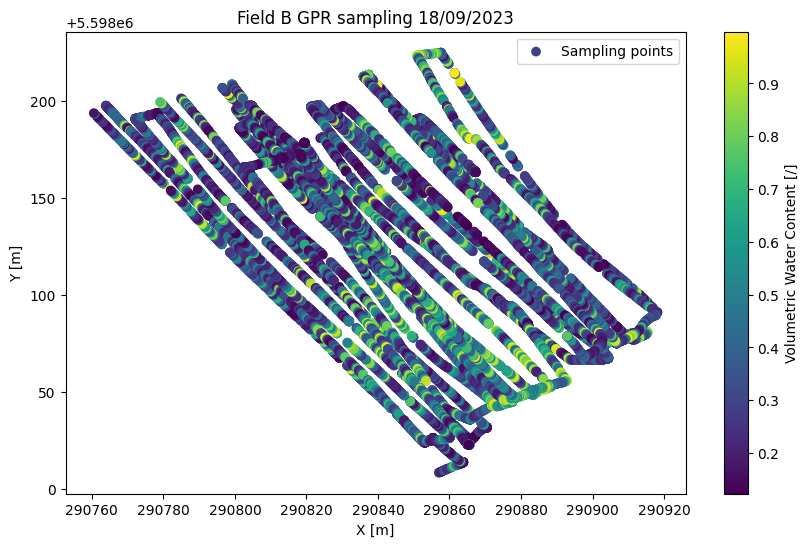

In [139]:
# Read csv file
Studied_field = import_data(field_path)[sample_number]

# Convert latitude and longitude to UTM coordinates
utm_x, utm_y = transformer.transform(Studied_field['x'].values, Studied_field['y'].values)

# Plot the sampling points
plt.figure(figsize=(10, 6))
scatter = plt.scatter(utm_x, utm_y, c=Studied_field['vwc'], cmap='viridis', label='Sampling points')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title(f'Field {field_letter} GPR sampling {dates[sample_number]}')
cb = plt.colorbar(scatter)
cb.set_label('Volumetric Water Content [/]')
plt.grid(False)
plt.legend()
plt.show()

In [140]:
# grid data to ? m resolution
res = 0.00002  
df_grid, grid_matrix, rows, cols = gs.Gridding.grid_data(Studied_field, 'x', 'y', 'vwc', res)

# remove nans
df_grid = df_grid[df_grid['Z'].isnull() == False]

# normal score transformation
data = df_grid['Z'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution='normal').fit(data)
df_grid['Nbed'] = nst_trans.transform(data) 

# compute experimental (isotropic) variogram
coords = df_grid[['X','Y']].values
values = df_grid['Nbed']

maxlag = 10      # maximum range distance
n_lags = 100         # num of bins

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, maxlag=maxlag, normalize=False)

# use exponential variogram model
V1.model = 'exponential'
V1.parameters

[6.501629162982821e-05, 1.057972169540935, 0]

## Initialize interpolation grid

In [141]:
# define coordinate grid
xmin = np.min(df_grid['X']); xmax = np.max(df_grid['X'])     # min and max x values
ymin = np.min(df_grid['Y']); ymax = np.max(df_grid['Y'])     # min and max y values

Pred_grid_xy = gs.Gridding.prediction_grid(xmin, xmax, ymin, ymax, res)

In [142]:
print(Pred_grid_xy.shape)
print(df_grid.shape)

(11270, 2)
(2325, 6)


## Simple kriging
Simple kriging assumes that the mean is stationary and known. The data is treated as a residual from the mean, which is computed as the average of conditioning points. Sometimes this is a good assumption, but in some cases it is not. We will apply it here to see what happens.

In [143]:
# set variogram parameters
azimuth = 0
nugget = V1.parameters[2]

# the major and minor ranges are the same in this example because it is isotropic
major_range = V1.parameters[0]
minor_range = V1.parameters[0]
sill = V1.parameters[1]
vtype = 'Exponential'

# save variogram parameters as a list
vario = [azimuth, nugget, major_range, minor_range, sill, vtype]


k = 100         # number of neighboring data points used to estimate a given point
rad = 50000     # 50 km search radius

# est_SK is the estimate and var_SK is the variance
est_SK, var_SK = gs.Interpolation.skrige(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', k, vario, rad)

  0%|          | 0/11270 [00:00<?, ?it/s]

ValueError: could not broadcast input array from shape (4,) into shape (3,)

In [ ]:
print(azimuth, nugget, major_range, minor_range, sill, vtype)

0 0 0.00025329036101605964 0.00025329036101605964 1.2046181674901943 Exponential


Ordinary kriging

In [ ]:
k = 100
est_OK, var_OK = gs.Interpolation.okrige(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', k, vario, rad) # estimation and variance

# reverse normal score transformation
var_OK[var_OK < 0] = 0; # make sure variances are non-negative
std_OK = np.sqrt(var_OK) # convert to standard deviation (this should be done before back transforming!!!)

# reshape
est = est_OK.reshape(-1,1)
std = std_OK.reshape(-1,1)

# back transformation
pred_trans = nst_trans.inverse_transform(est)
std_trans = nst_trans.inverse_transform(std)
std_trans = std_trans - np.min(std_trans)

In [ ]:
# plot ordinary kriging and stnadard deviation
fig = plt.figure()
plt.subplot(121) 
im = plt.scatter(Pred_grid_xy[:,0],Pred_grid_xy[:,1], c = pred_trans, vmin = -400, vmax = 600, marker=".", s = 50,
                cmap = 'gist_earth')       # scatter plot for location map
plt.title('Ordinary kriging')                                    # add plot title
plt.xlabel('X [m]'); plt.ylabel('Y [m]')                          # set axis labels
plt.locator_params(nbins=5)# set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-400, 600, 11)) # add vertical color bar
cbar.set_label("Bed elevation [m]", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')

plt.subplot(122) 
im = plt.scatter(Pred_grid_xy[:,0],Pred_grid_xy[:,1], c = std_trans, vmin = 0, vmax = 150, marker=".", s = 50,
                cmap = 'magma')       # scatter plot for location map
plt.title('Standard deviation')                                    # add plot title
plt.xlabel('X [m]'); plt.ylabel('Y [m]')                          # set axis labels
plt.locator_params(nbins=5)# set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(0, 250, 6)) # add vertical color bar
cbar.set_label("Standard deviation [m]", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.3)
plt.show()